## Experiment 1

_June 24, 2021_

This is a conceptual replication of Zhu et al. (2020) "Bayesian Sampler" paper. I have condensed things down to one block or measure per question (rather than 3 identical blocks) and have asked about London and Los Angeles with events that should be fairly but not perfectly correlated: Warm/Sunny and cold/rainy.

The analyses below seek to replicate the findings from my draft paper in preparation now (Powell, 2021).

At this point I am not doing anything to address the rounding inherent in participant's responses, although that could be a nice thing to add. See simulations notebook for how to do that.

In [36]:
import numpyro
numpyro.util.set_host_device_count(4)
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive, DiscreteHMCGibbs
from numpyro.infer.initialization import init_to_value, init_to_feasible

from jax import numpy as jnp
from jax import random

import re 

import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import siuba as s
from siuba import _

%run -i 'model_helpers.py'
%run -i 'models.py'

In [37]:

df = pd.read_csv("data/exp1-passing.csv")
rng = np.random.default_rng(123)
# df = df >> s.filter(_.pass_check==1) >> s.mutate(response = _.response.replace({0:.001, 1:.999}))
# df = df >> s.filter(_.pass_check==1) #, _.response > 0.0, _.response < 1.0)
df = (df >> 
    s.mutate(
        response = _.response.replace({0:.01, 1:.99}),
        condition = s.case_when({
            _.condition=="coldrainy_london": 0,
            _.condition=="sunnywarm_london": 1,
            _.condition=="coldrainy_LA": 2,
            _.condition=="sunnywarm_LA": 3
        })
    )
)

# df["response"] = rng.beta(df.response*25, (1-df.response)*25)
print(df.shape)
df.head()

(7520, 13)


,ID,age,gender,race,zip,StartDate,duration,pass_check,response,querytype,weather_cond,location_cond,condition
0,0,53,Man,White,72088.0,2021-05-10T13:52:06Z,617,1,0.7,A,coldrainy,london,0
1,1,27,Woman,White,28390.0,2021-05-10T13:59:41Z,1075,1,0.2,A,coldrainy,london,0
2,2,28,Man,White,10956.0,2021-05-10T14:12:27Z,543,1,0.5,A,coldrainy,london,0
3,3,32,Man,White,56187.0,2021-05-10T14:15:45Z,805,1,0.5,A,coldrainy,london,0
4,4,31,Man,White,66021.0,2021-05-10T14:22:09Z,491,1,0.7,A,coldrainy,london,0


In [38]:
# df_test = df >> s.filter(_.ID < 21) >> s.filter(_.condition < 2) # just london questions
df_test = df
# df_test = df >> s.filter(_.ID > 80) # different respondents
# df_test = df >> s.filter(_.ID > 61, _.duration > 600, _.duration < 1800)
X_data, y_data = make_model_data(df_test) # see data_helpers.py
print(len(y_data))
print(min(y_data), max(y_data))

7520
0.01 0.99


# Relative Frequency model


In [39]:
def calc_prob(theta, X_num, X_denom):

    numerator = jnp.sum(theta*X_num, axis=-1)
    denom = jnp.sum(theta*X_denom, axis=-1)
    
    return jnp.divide(numerator, denom)

def relative_freq(data, y=None):

    rounded_to = .1
    # Data processing
    trial, subj, cond = data["trial"], data["subj"], data["cond"]
    n_Ps, n_conds = np.unique(subj).shape[0], np.unique(cond).shape[0] 
    
    # setup "design matrix" (of sorts)
    X_num, X_denom = jnp.stack([num_vecs[i] for i in trial]), jnp.stack([denom_vecs[i] for i in trial])

    # population level parameters/priors
#     sigma = numpyro.sample("sigma", dist.HalfCauchy(.1)) # for Normal() response noise version
    k = numpyro.sample("k", dist.HalfNormal(50)) # noise parameter

    # need a theta per person-query
    with numpyro.plate("cond", n_Ps*n_conds):
        thetas = numpyro.sample("theta", dist.Dirichlet(jnp.ones(4)))
    
    theta_ind = ((subj*n_conds)+cond)
    theta = thetas[theta_ind,:]
        
    pi = calc_prob(theta, X_num, X_denom)

    with numpyro.plate("data", len(trial)):
##        accounting for rounding
        # y_err = numpyro.sample("y_err", dist.Beta(1,1))
        # y_err = (y_err - .50)*rounded_to        
        # true_obs = y + y_err if y is not None else None
        
        true_obs = y if y is not None else None
        yhat = numpyro.sample("yhat", dist.Beta(pi*k, (1-pi)*k), obs=true_obs)
#         y_true = numpyro.sample("y_true", dist.Beta(pi*k, (1-pi)*k))
#         numpyro.sample("y_hat", dist.Normal(y_true + y_err, .0001), obs=y)
        
        # not accounting for rounding
        # yhat = numpyro.sample("yhat", dist.Beta(pi*k, (1-pi)*k), obs=y)

In [40]:
mcmc_rf = MCMC(NUTS(relative_freq, target_accept_prob=.90,
                    init_strategy = init_to_value(values={"y_err":.50})), 
               num_warmup=500, 
               num_samples=500, 
               num_chains=2)

mcmc_rf.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [41]:
az_data_rf = make_arviz_data(mcmc_rf, relative_freq, X_data) # see model_helpers.py

In [42]:
print("num divergences =", count_divergences(az_data_rf))
# az.summary(az_data_rf, var_names=['k'])

num divergences = 0


In [34]:
def plot_model_preds(orig_data, model_data):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_xlim(0,1)
    axes[1].set_xlim(0,1)
    axes[0].set_ylim(0,1)
    axes[1].set_ylim(0,1)
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
#     fig.suptitle('Model')

    d = orig_data
    d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat # 
    print("Participant mean response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
    sns.scatterplot(ax = axes[0], x = d.preds, y = d.response)

    trial_df = (d
                .groupby(["querytype", "condition"])
                .agg({"preds":"mean", "response":"mean"})
               )
    print("Query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
    sns.scatterplot(ax = axes[1], x = trial_df.preds, y = trial_df.response)
    az.plot_ppc(ax=axes[2], data=model_data, data_pairs={"yhat":"yhat"}, kind="cumulative", num_pp_samples=500, legend=False)
    axes[0].set_title("Avg. participant-level responses")    
    axes[1].set_title("Avg. responses for each query")
    axes[2].set_title("posterior predictive")


<ipython-input-13-c3ed1640ec9e>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat #


Participant mean response corr =  0.612
Query-level corr 0.727


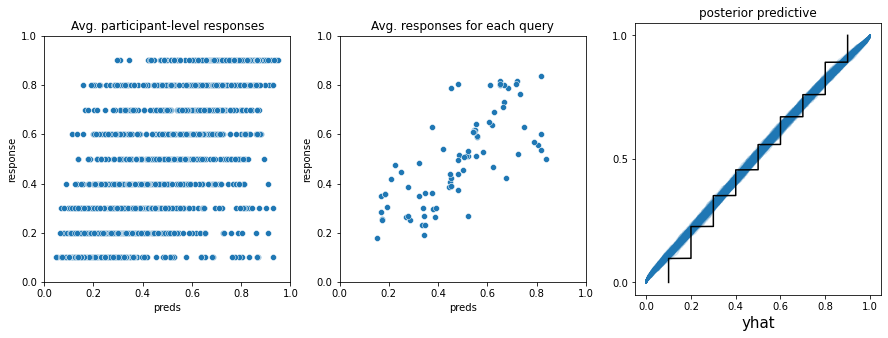

In [14]:
plot_model_preds(df_test, az_data_rf)

# Bayesian sampler model


In [43]:
mcmc_bs_simple = MCMC(NUTS(bayesian_sampler_simple, target_accept_prob=.90,
                          # init_strategy = init_to_value(values={"y_err":.50})
                          ),
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [44]:
az_data_bs_simple = make_arviz_data(mcmc_bs_simple, bayesian_sampler_simple, X_data) # see model_helpers.py

In [45]:
print("num divergences =", count_divergences(az_data_bs_simple))
az.summary(az_data_bs_simple, var_names=['d_base', 'k'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base[0],0.953,0.544,-0.091,1.890,0.015,0.011,1511.0,1154.0,1.0
d_base[1],-0.437,0.397,-1.142,0.306,0.011,0.009,1310.0,1146.0,1.0
d_base[2],1.131,0.584,0.188,2.290,0.017,0.015,1560.0,828.0,1.0
d_base[3],-0.294,0.429,-1.156,0.455,0.012,0.009,1255.0,1153.0,1.0
d_base[4],3.199,0.900,1.683,4.927,0.021,0.017,2398.0,903.0,1.0
...,...,...,...,...,...,...,...,...,...
d_base[90],0.867,0.582,-0.231,1.892,0.015,0.012,1681.0,1078.0,1.0
d_base[91],0.669,0.454,-0.143,1.540,0.011,0.009,1774.0,1358.0,1.0
d_base[92],3.498,0.952,1.880,5.281,0.021,0.017,2419.0,1216.0,1.0
d_base[93],-0.079,0.378,-0.782,0.595,0.011,0.008,1250.0,1486.0,1.0


Participant mean response corr =  0.696
Query-level corr 0.823


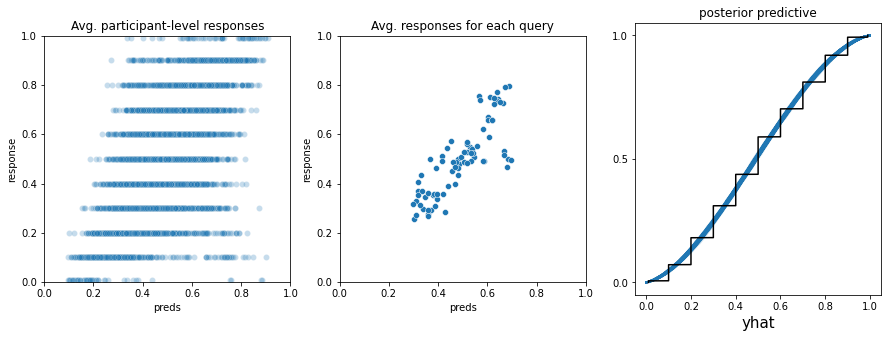

In [48]:
def plot_model_preds(orig_data, model_data):
    from matplotlib import pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].set_xlim(0,1)
    axes[1].set_xlim(0,1)
    axes[0].set_ylim(0,1)
    axes[1].set_ylim(0,1)
    axes[0].set_aspect(1)
    axes[1].set_aspect(1)
#     fig.suptitle('Model')

    d = orig_data
    d["preds"] = model_data.posterior_predictive.mean(dim=['chain', 'draw']).yhat # 
    print("Participant mean response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
    sns.scatterplot(ax = axes[0], x = d.preds, y = d.response, alpha=.25)

    trial_df = (d
                .groupby(["querytype", "condition"])
                .agg({"preds":"mean", "response":"mean"})
               )
    print("Query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
    sns.scatterplot(ax = axes[1], x = trial_df.preds, y = trial_df.response)
    az.plot_ppc(ax=axes[2], data=model_data, data_pairs={"yhat":"yhat"}, kind="cumulative", num_pp_samples=500, legend=False)
    axes[0].set_title("Avg. participant-level responses")    
    axes[1].set_title("Avg. responses for each query")
    axes[2].set_title("posterior predictive")

plot_model_preds(df_test, az_data_bs_simple)

### Complex

In [49]:
mcmc_bs = MCMC(NUTS(bayesian_sampler_complex, target_accept_prob=.90), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_bs.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [50]:
az_data_bs = make_arviz_data(mcmc_bs, bayesian_sampler_complex, X_data) # see model_helpers.py
print("num divergences =", count_divergences(az_data_bs))
# az.summary(az_data_bs, var_names=['d_base', 'd_delta', 'k'])

num divergences = 0


Participant mean response corr =  0.716
Query-level corr 0.854


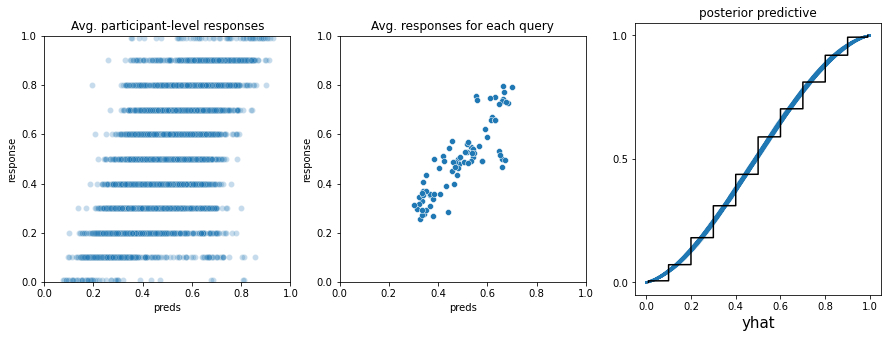

In [51]:
plot_model_preds(df_test, az_data_bs)

# Probability theory plus noise (PT+N) model

### Simple

In [52]:
mcmc_ptn_simple = MCMC(NUTS(PTN_simple, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.65
Query-level corr 0.787


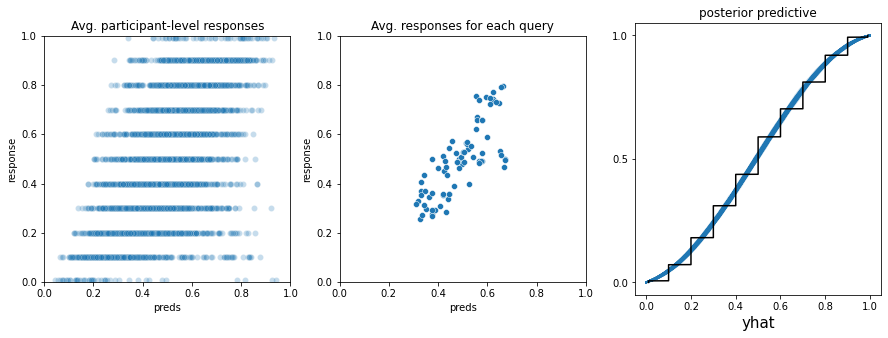

In [53]:
az_data_ptn_simple = make_arviz_data(mcmc_ptn_simple, PTN_simple, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_simple)

### Complex

In [54]:
mcmc_ptn = MCMC(NUTS(PTN_complex, target_accept_prob=.80), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=2)

mcmc_ptn.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [55]:
# mcmc_ptn.print_summary()

Participant mean response corr =  0.698
Query-level corr 0.851


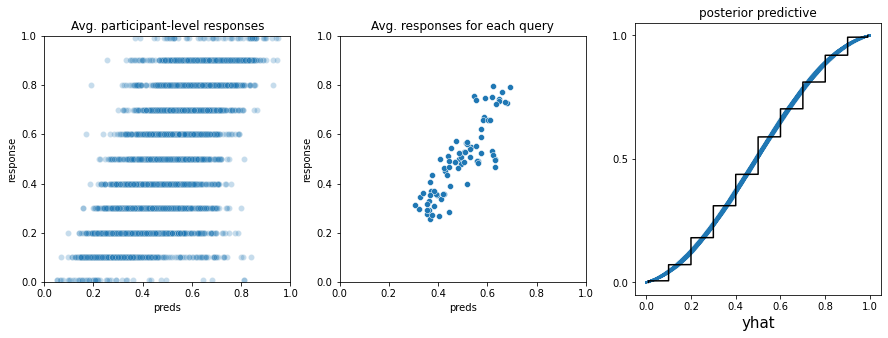

In [56]:
az_data_ptn = make_arviz_data(mcmc_ptn, PTN_complex, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn)

In [57]:
az.compare(
    {
        "P+TN complex":az_data_ptn, 
        "Bayesian Sampler complex": az_data_bs, 
        "P+TN simple":az_data_ptn_simple, 
        "Bayesian Sampler simple": az_data_bs_simple, 
        "Relative Freq.":az_data_rf
    }, 
    scale="deviance", ic="loo")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Bayesian Sampler complex,0,-4487.989550,798.776332,0.000000,0.587945,152.167146,0.000000,True,deviance
Bayesian Sampler simple,1,-4350.262937,727.141800,137.726613,0.086550,155.990732,29.064782,True,deviance
P+TN complex,2,-4345.996417,690.505150,141.993133,0.302130,142.819792,44.014189,True,deviance
P+TN simple,3,-3944.439182,583.996670,543.550367,0.023377,151.148590,60.552444,True,deviance
Relative Freq.,4,-863.918632,927.414589,3624.070918,0.000000,176.375846,88.072904,True,deviance


# Summary and comparison of models

All three models have now been implemented as probabilistic programs, and we have obtained samples for each. [This paper](https://arxiv.org/abs/1507.04544) describes how to compare them using information criteria.

* Both the PT+N and Bayesian sampler models are far better than the naive relative frequency model.
* If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then the PT+N and Bayesian sampler models are essentially indistinguishable. 
* But if you constrain $\beta \in [0,1]$, then according to $loo_{ic}$ the PT+N model is the best (now that I have fixed my code) and the Bayesian Sampler is in second. 

# Hierarchical Bayesian Sampler

# Simple

In [58]:
mcmc_bs_mlm_simple = MCMC(NUTS(bayesian_sampler_simple_mlm_d, target_accept_prob=.95), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)
# 
mcmc_bs_mlm_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.696
Query-level corr 0.826


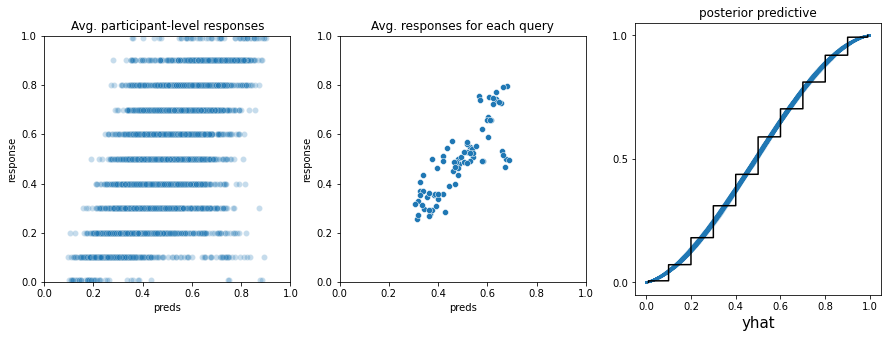

In [59]:
az_data_bs_mlm_simple = make_arviz_data(mcmc_bs_mlm_simple, bayesian_sampler_simple_mlm_d, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm_simple)

In [60]:
az.summary(az_data_bs_mlm_simple, var_names=['d_base_sd','d_base_pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.772,0.231,1.374,2.224,0.005,0.003,2486.0,4280.0,1.0
d_base_pop,1.987,0.231,1.551,2.417,0.004,0.003,2754.0,4881.0,1.0


## Complex

In [61]:
mcmc_bs_mlm = MCMC(NUTS(bayesian_sampler_complex_mlm_d, target_accept_prob=.95), # need the higher prob and more samples to get good rhats
               num_warmup=2_000, 
               num_samples=2_000, 
               num_chains=4)
# 
mcmc_bs_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

Participant mean response corr =  0.714
Query-level corr 0.856


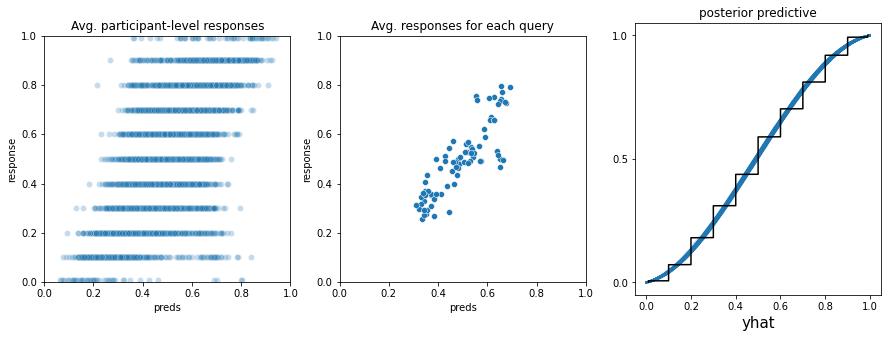

In [62]:
az_data_bs_mlm = make_arviz_data(mcmc_bs_mlm, bayesian_sampler_complex_mlm_d, X_data) # see model_helpers.py
plot_model_preds(df, az_data_bs_mlm)

In [63]:
az.summary(az_data_bs_mlm, var_names=['d_base_sd', 'd_delta_sd', 'd_delta_pop', 'd_base_pop'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.681,0.220,1.280,2.094,0.005,0.004,1894.0,2735.0,1.0
d_delta_sd,0.253,0.162,0.019,0.541,0.004,0.003,1811.0,3410.0,1.0
d_delta_pop,0.465,0.112,0.256,0.677,0.002,0.001,5133.0,5186.0,1.0
d_base_pop,1.147,0.220,0.748,1.569,0.005,0.003,2083.0,3270.0,1.0


# Hierarchical PT+N

## Simple

<!-- # Hierarchical PT+N -->


In [64]:
mcmc_ptn_mlm_simple = MCMC(NUTS(PTN_simple_mlm, target_accept_prob=.95), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_ptn_mlm_simple.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.651
Query-level corr 0.784


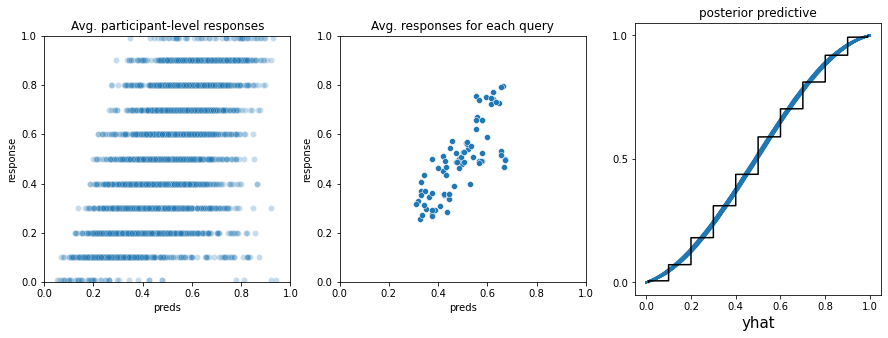

In [65]:
az_data_ptn_mlm_simple = make_arviz_data(mcmc_ptn_mlm_simple, PTN_simple_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm_simple)

## Complex

In [66]:
mcmc_ptn_mlm = MCMC(NUTS(PTN_complex_mlm, target_accept_prob=.95), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_ptn_mlm.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [67]:
# mcmc_ptn_mlm.print_summary()

Participant mean response corr =  0.7
Query-level corr 0.854


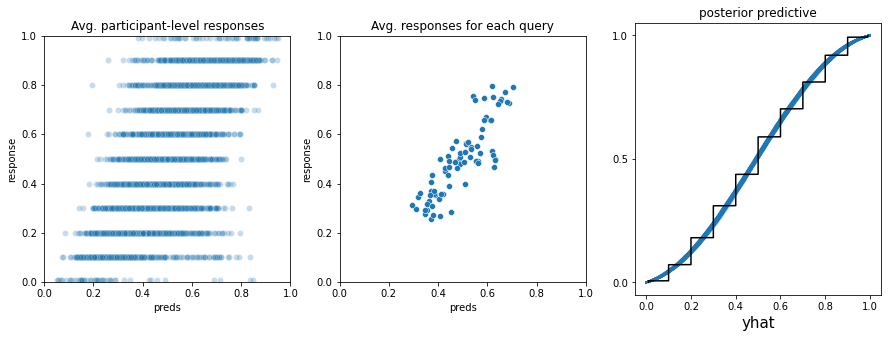

In [68]:
az_data_ptn_mlm = make_arviz_data(mcmc_ptn_mlm, PTN_complex_mlm, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm)

## "Hybrid" —unconstrainted $\beta$ or PT+N without conditional probability account

In [69]:
# %run -i 'models.py'
mcmc_ptn_mlm_simplecond = MCMC(NUTS(PTN_complex_mlm_simplecond, target_accept_prob=.95), 
               num_warmup=1_000, 
               num_samples=1_000, 
               num_chains=4)

mcmc_ptn_mlm_simplecond.run(random.PRNGKey(0), X_data, y_data)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Participant mean response corr =  0.72
Query-level corr 0.874


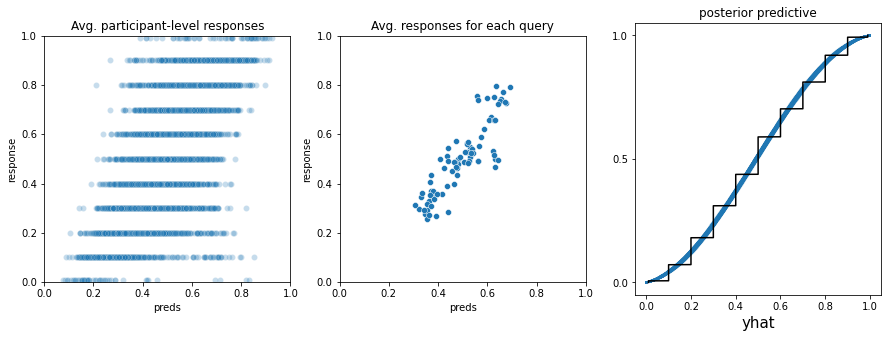

In [70]:
az_data_ptn_mlm_simplecond = make_arviz_data(mcmc_ptn_mlm_simplecond, PTN_complex_mlm_simplecond, X_data) # see model_helpers.py
plot_model_preds(df, az_data_ptn_mlm_simplecond)

In [73]:
az.compare(
    {
        "P+TN complex":az_data_ptn, 
        "Bayesian Sampler complex": az_data_bs, 
        "P+TN simple":az_data_ptn_simple, 
        "Bayesian Sampler simple": az_data_bs_simple, 
        "Relative Freq.":az_data_rf,
        "PTN_complex_mlm":az_data_ptn_mlm, 
        "PTN_simple_mlm":az_data_ptn_mlm_simple, 
        "BS_complex_mlm": az_data_bs_mlm,
        "BS_simple_mlm": az_data_bs_mlm_simple,
        "complex_hybrid": az_data_ptn_mlm_simplecond
    }, 
    scale="deviance", ic="loo", method="BB-pseudo-BMA")

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very differen

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
complex_hybrid,0,-4669.676838,705.128289,0.000000,NaN,177.129066,0.000000,True,deviance
BS_complex_mlm,1,-4556.550624,720.541358,113.126214,NaN,151.021460,21.297587,True,deviance
Bayesian Sampler complex,2,-4487.989550,798.776332,181.687288,NaN,143.851221,24.933975,True,deviance
PTN_complex_mlm,3,-4393.370401,674.371773,276.306437,NaN,154.995874,29.909971,True,deviance
BS_simple_mlm,4,-4367.734101,695.750410,301.942737,NaN,149.882065,31.596301,True,deviance
Bayesian Sampler simple,5,-4350.262937,727.141800,319.413901,NaN,143.226666,34.195315,True,deviance
P+TN complex,6,-4345.996417,690.505150,323.680421,NaN,145.670607,34.464024,True,deviance
P+TN simple,7,-3944.439182,583.996670,725.237656,NaN,150.585043,51.821517,True,deviance
PTN_simple_mlm,8,-3941.935369,585.267212,727.741468,NaN,141.800630,51.745573,True,deviance
Relative Freq.,9,-863.918632,927.414589,3805.758206,0.0,150.053701,99.710422,True,deviance


This replicates the results from the Zhu et al. paper very nicely.

# Comparing conditional probability judgments

Bayesian Sampler conditional response corr =  0.799
Bayesian Sampler conditional query-level corr 0.973


<AxesSubplot:xlabel='preds', ylabel='response'>

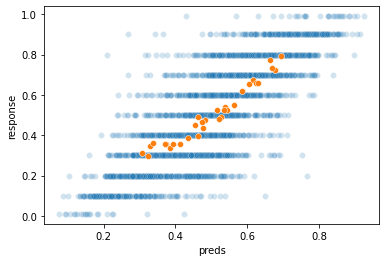

In [94]:
# zoom in on conditional trials

d = df
d["preds"] = az_data_ptn_mlm_simplecond.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "weather_cond", "location_cond"])
                .agg({"preds":"mean", "response":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
sns.scatterplot(x = d.preds, y = d.response, alpha=.2)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
sns.scatterplot(x = trial_df.preds, y = trial_df.response)

Bayesian Sampler conditional response corr =  0.769
Bayesian Sampler conditional query-level corr 0.945


<AxesSubplot:xlabel='preds', ylabel='response'>

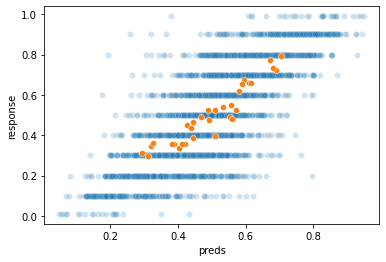

In [93]:
d = df
d["preds"] = az_data_ptn_mlm.posterior_predictive.mean(dim=['chain', 'draw']).yhat
d = d[d.querytype.transform(is_cond).astype("bool")]
trial_df = (d
                .groupby(["querytype", "weather_cond", "location_cond"])
                .agg({"preds":"mean", "response":"mean"}).reset_index()
               )

print("Bayesian Sampler conditional response corr = ", np.round(np.corrcoef(d.response, d.preds)[0,1],3))
sns.scatterplot(x = d.preds, y = d.response, alpha=.2)
print("Bayesian Sampler conditional query-level corr", np.round(np.corrcoef(trial_df.response, trial_df.preds)[0,1],3))
sns.scatterplot(x = trial_df.preds, y = trial_df.response)

The difference is't striking at a glance, but the unrestricted Bayesian Sampler does a better job predicting for conditional trials than does the PT+N model. The difference in fits for both trial-level and response-level is actually about 5% of the variance though, so that's substantial. 

# Summary of hierarchical models

If you allow values of $\beta$ greater than 1 in Bayesian Sampler model, then a hierarchical implementation of that model pulls ahead of a hierarchical implementation of PT+N. If you strip out the constructive account of conditional probability judgments from PT+N, then it is perhaps slightly better still, but it is not reliably distinguishable by $loo_{ic}$. The models are fundamentally equivalent at this point so any differences probably owe to implementation of the priors and internal parameterization of $d$ vs $N$.

If these results are to be trusted it's pretty decisive in favor of the Bayesian Sampler models account of conditional probability (these judgments are just like simple probability judgments) and therefore the Bayesian Sampler theory. As for whether we should appeal to "noise" or "priors", as Zhu and colleage's point out they are essentially indistinguishable at this point. Certain degrees of noise act like certain priors, and vice versa.

### A few concerns

* Am I inadvertantly putting a weird prior on d in the hierarchical models? — irrelevant to model comparison b/c they are equated

# Inspecting the models

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

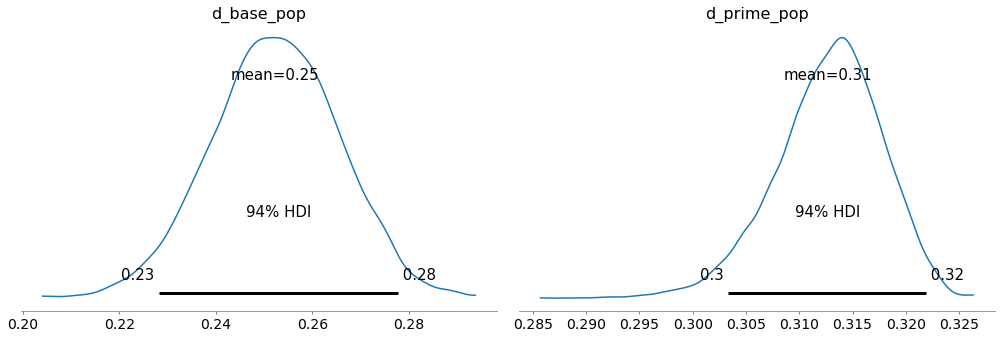

In [82]:
# az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_pop"], transform=np.exp)
# # az.plot_posterior(data=az_data_bs_mlm, var_names=["beta_sd", "N_prime_sd", "N_delta_sd"], transform=np.exp)

# az_data_bs_mlm.posterior["N_base_pop"] = 1 + np.exp(az_data_bs_mlm.posterior.N_prime_pop) + np.exp(az_data_bs_mlm.posterior.N_delta_pop)
# az.plot_posterior(az_data_bs_mlm, var_names=["N_base_pop"])
# az.plot_posterior(az_data_bs_mlm, var_names=["N_prime_pop"], transform = lambda x: 1 + np.exp(x))

## Implied d
az_data_bs_mlm.posterior["d_prime_pop"] = az_data_bs_mlm.posterior.d_base_pop + np.exp(az_data_bs_mlm.posterior.d_delta_pop)
az.plot_posterior(az_data_bs_mlm, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/3.)


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

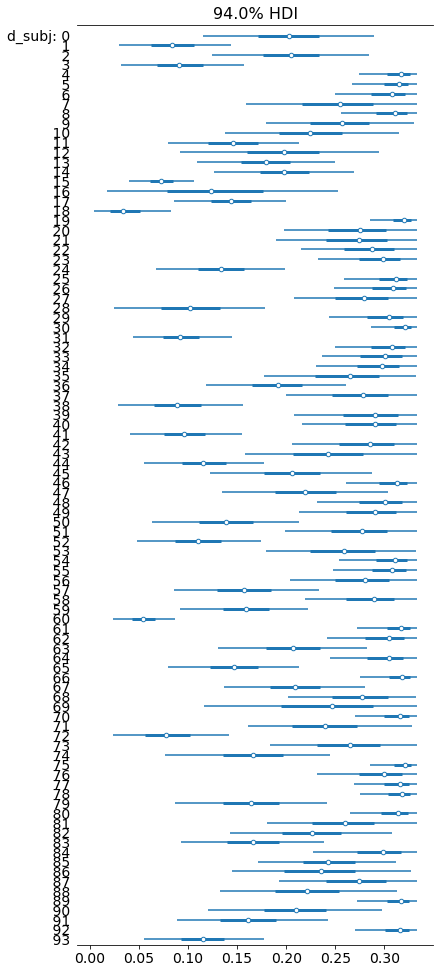

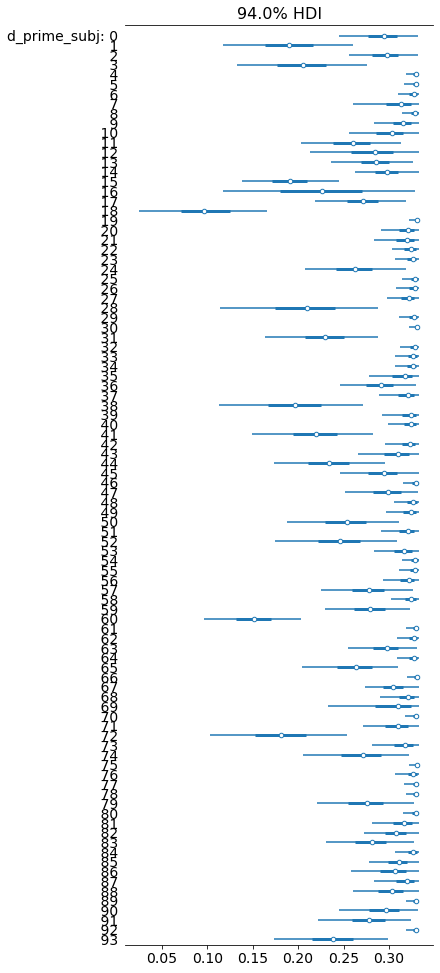

In [83]:
# az.plot_forest(data=az_data_bs_mlm, var_names=["beta_subj"],  combined=True)
# az.plot_forest(data=az_data_bs_mlm, var_names=["N_subj"], combined=True)
# az.plot_forest(data=az_data_bs_mlm, var_names=["N_prime_subj"], combined=True)

## implied d
az.plot_forest(data=az_data_bs_mlm, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_bs_mlm, var_names=["d_prime_subj"], combined=True)

In [90]:
print("num divergences =", count_divergences(az_data_bs_mlm))
az.summary(az_data_bs_mlm, var_names=['d_base_sd','d_delta_sd'])

num divergences = 0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
d_base_sd,1.681,0.220,1.280,2.094,0.005,0.004,1894.0,2735.0,1.0
d_delta_sd,0.253,0.162,0.019,0.541,0.004,0.003,1811.0,3410.0,1.0


Note how many of the subject-level estimates are butting up against .33---suggests the model is too constrained.

## hybrid

array([<AxesSubplot:title={'center':'d_base_pop'}>,
       <AxesSubplot:title={'center':'d_prime_pop'}>], dtype=object)

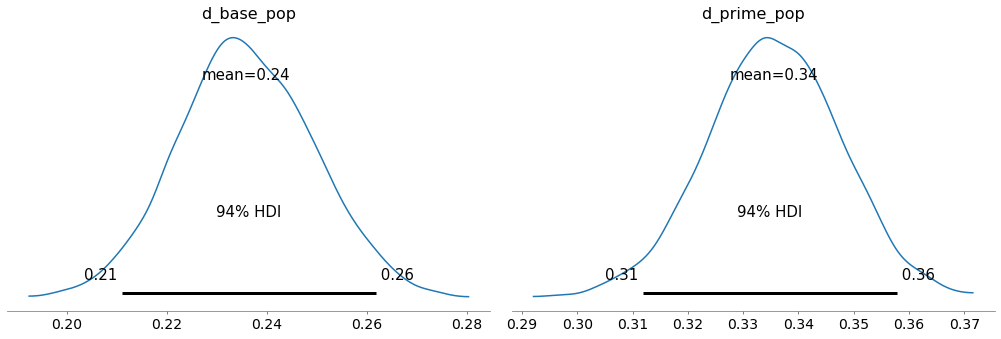

In [87]:
az_data_ptn_mlm_simplecond.posterior["d_prime_pop"] = az_data_ptn_mlm_simplecond.posterior.d_base_pop + np.exp(az_data_ptn_mlm_simplecond.posterior.d_delta_pop)
az.plot_posterior(az_data_ptn_mlm_simplecond, var_names = ["d_base_pop", "d_prime_pop"], transform=lambda x: np.exp(-np.logaddexp(0, -x))/2)

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

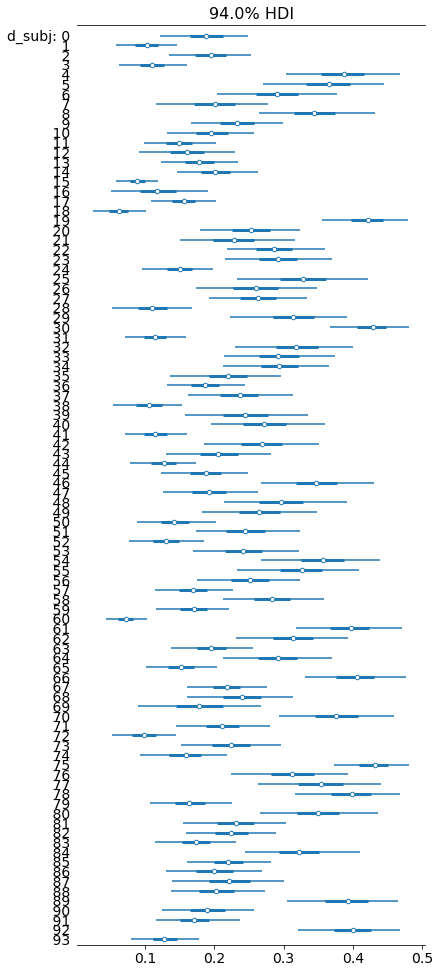

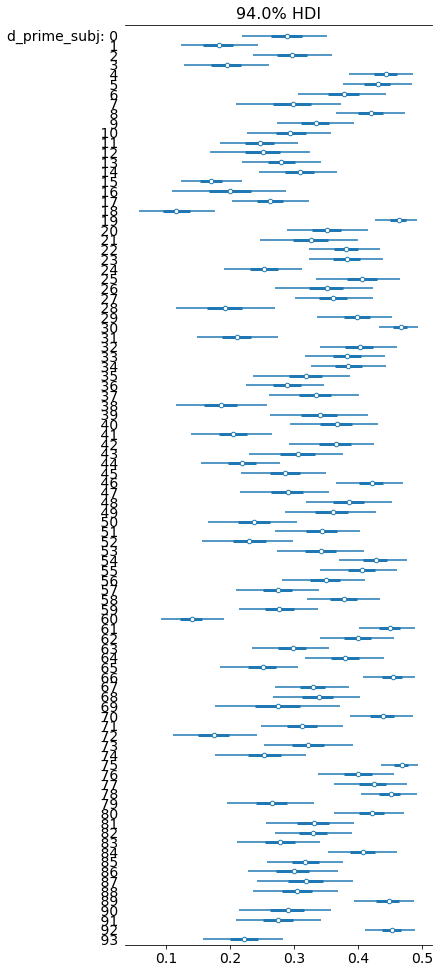

In [89]:
az.plot_forest(data=az_data_ptn_mlm_simplecond, var_names=["d_subj"], combined=True)
az.plot_forest(data=az_data_ptn_mlm_simplecond, var_names=["d_prime_subj"], combined=True)

Now the estimates have room to breathe!